In [151]:
import os
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense;
from tensorflow.keras.models import Sequential;
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

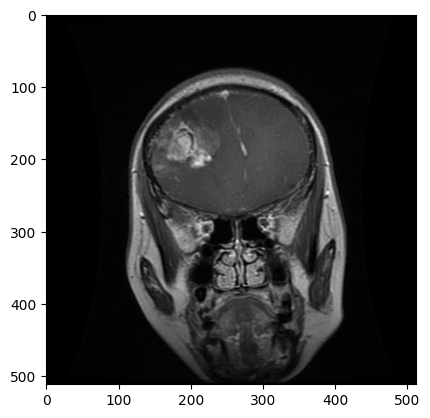

In [152]:
DATA = r"../kaggle/mri/Training" #reading the data
#DATA = r"kaggle/Training/"

CATEGORIES = ["glioma","meningioma","notumor","pituitary"] #defining the 4 categories that we have
for category in CATEGORIES:
    path = os.path.join(DATA,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        # plt.show()
        # plt.axis("off")
        break
    break

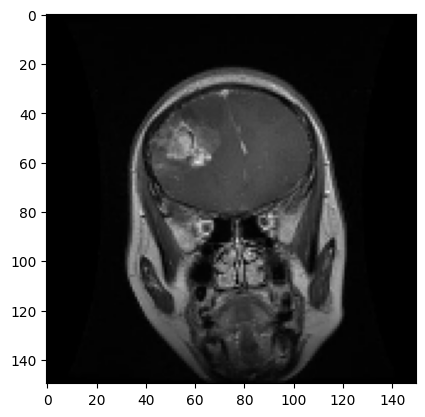

In [153]:
IMG_SIZE = 150 #defining our image size
new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))#scaling down our images  
plt.imshow(new_array,cmap = "gray")
# plt.axis("off")

In [154]:
training_data = [] #manipulating our training data

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATA,category)
        class_num = CATEGORIES.index(category) #defining the different categories of the images in our data
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) #loading the images in grayscale
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num]) #adding our data in to the training_data list which we will use to define our X and y for train-tets split
            except Exception as e:
                pass
create_training_data()

In [155]:
X = [] #used for storing  the features
y = [] #used for storing the labels
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)
print(X.shape)

(5712, 150, 150)
(5712, 150, 150, 1)


In [156]:
#one-hot eencoding our values
y = to_categorical(y, num_classes = 4)
print(y)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [157]:
#splitting the data into training and validaton set
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (4569, 150, 150, 1)
x_test shape (1143, 150, 150, 1)
y_train shape (4569, 4)
y_test shape (1143, 4)


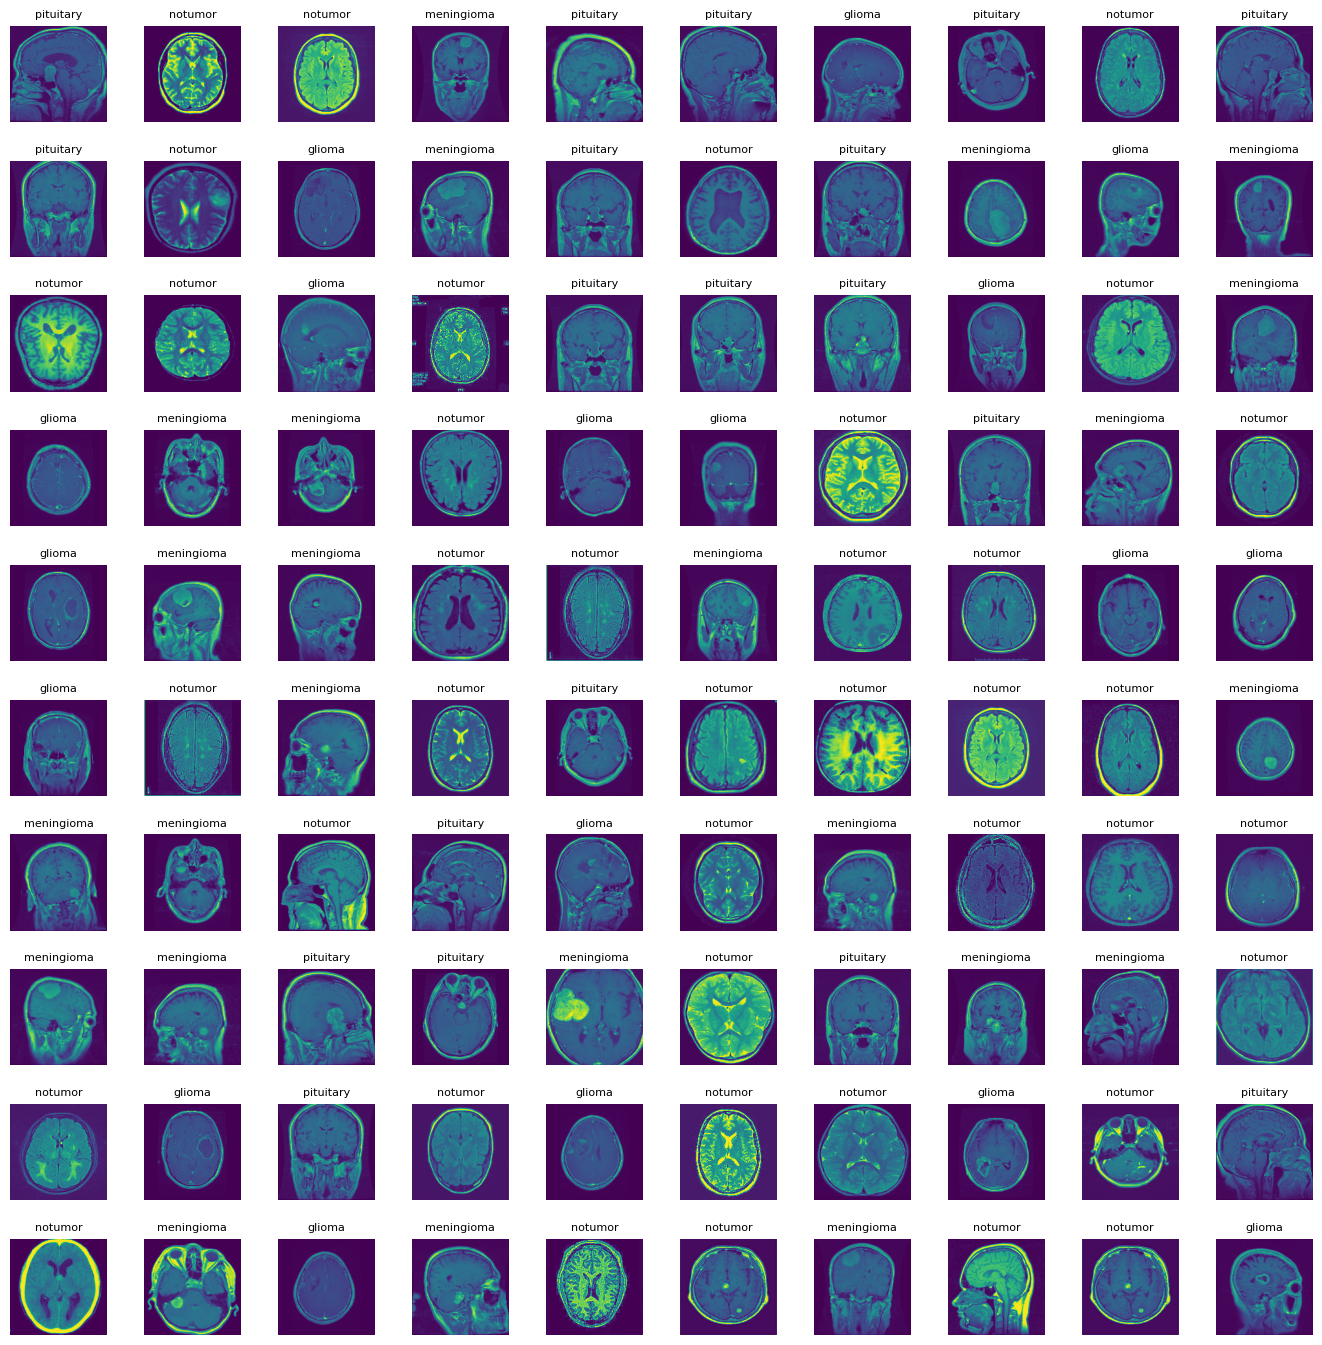

In [158]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    # label_index = int(Y_train[index  == 1])
    label_index = np.argmax(Y_train[index])
    axes[i].set_title(CATEGORIES[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

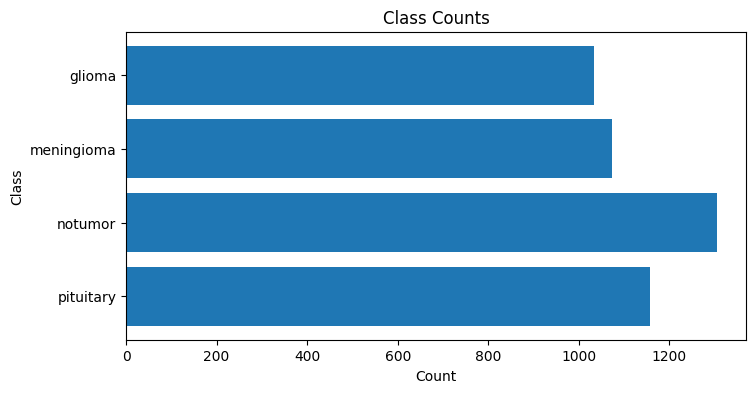

In [159]:
# Assuming Y_train is your one-hot encoded labels
class_counts = np.sum(Y_train, axis=0)

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))
plt.barh(CATEGORIES, class_counts)
plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Class Counts')
plt.gca().invert_yaxis()  # Invert y-axis to display Class 1 at the top
plt.show()

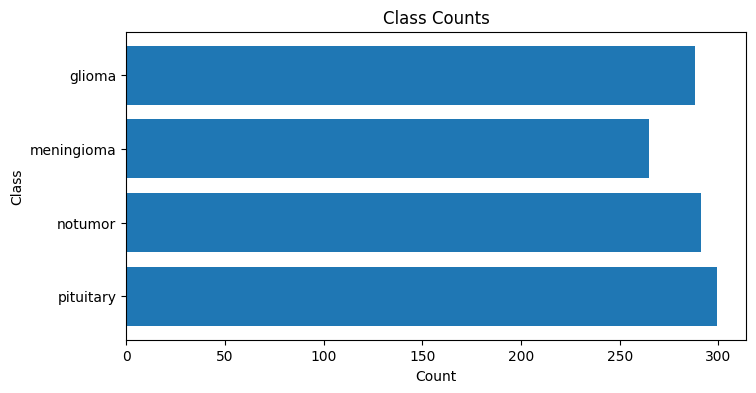

In [160]:
# in validation set
class_counts = np.sum(Y_val, axis=0)

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))
plt.barh(CATEGORIES, class_counts)
plt.xlabel('Count')
plt.ylabel('Class')
plt.title('Class Counts')
plt.gca().invert_yaxis()  # Invert y-axis to display Class 1 at the top
plt.show()

In [161]:
#defining our model
model = Sequential([
    Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(128, (3,3), activation='relu',padding = 'Same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Conv2D(256, (3,3), activation='relu',padding = 'Same'),
    MaxPooling2D(2,2),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=METRICS)


# Create an instance of ImageDataGenerator for data augmentation

EPOCHS = 50  
BATCH_SIZE = 40

early_stop = EarlyStopping(monitor='val_loss', patience=2)

datagen = ImageDataGenerator(  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  

In [162]:
model.summary() #checking what our final model would look like

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 37, 37, 128)      0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 37, 37, 128)      

In [163]:
datagen.fit(X_train)
history = model.fit_generator(
    datagen.flow(X_train,Y_train, batch_size=BATCH_SIZE),
    epochs = EPOCHS, 
    validation_data = (X_val,Y_val)
)    

#               callbacks=[early_stop],

C:\Users\PC\AppData\Local\Temp\ipykernel_3552\4063351736.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
115/115 [==============================] - 423s 4s/step - loss: 0.9800 - accuracy: 0.5752 - precision: 0.7526 - recall: 0.3955 - val_loss: 0.6897 - val_accuracy: 0.7174 - val_precision: 0.8259 - val_recall: 0.6185
Epoch 2/50
115/115 [==============================] - 408s 4s/step - loss: 0.6157 - accuracy: 0.7603 - precision: 0.7937 - recall: 0.7083 - val_loss: 0.5085 - val_accuracy: 0.7612 - val_precision: 0.7932 - val_recall: 0.7384
Epoch 3/50
115/115 [==============================] - 414s 4s/step - loss: 0.4881 - accuracy: 0.8035 - precision: 0.8282 - recall: 0.7746 - val_loss: 0.3906 - val_accuracy: 0.8644 - val_precision: 0.8866 - val_recall: 0.8346
Epoch 4/50
115/115 [==============================] - 406s 4s/step - loss: 0.4288 - accuracy: 0.8310 - precision: 0.8497 - recall: 0.8094 - val_loss: 0.3593 - val_accuracy: 0.8661 - val_precision: 0.8850 - val_recall: 0.8416
Epoch 5/50
115/115 [==============================] - 409s 4s/step - loss: 0.3587 - accuracy: 0.8591

Text(0.5, 0, 'epoch')

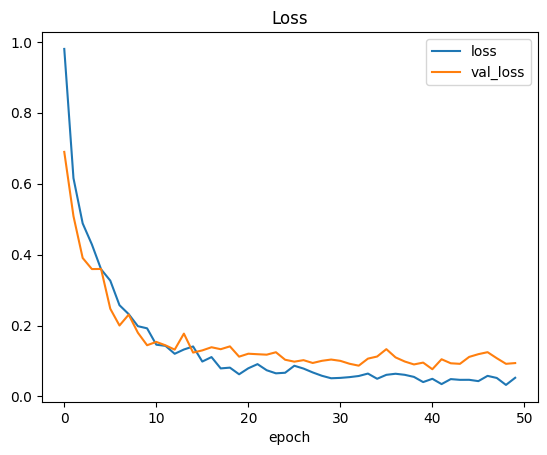

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

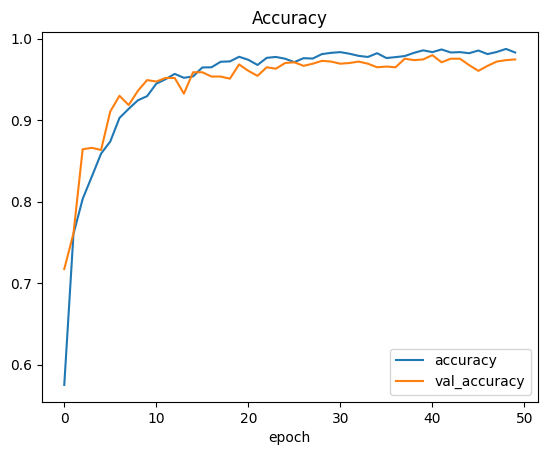

In [165]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

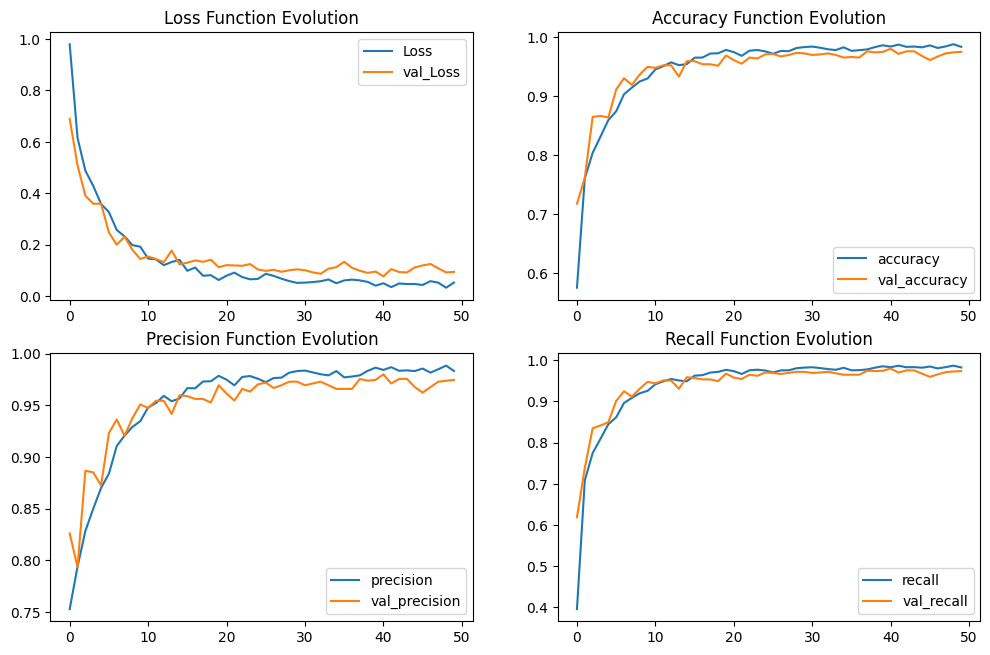

In [166]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

36/36 [==============================] - 27s 733ms/step - loss: 0.0942 - accuracy: 0.9746 - precision: 0.9746 - recall: 0.9738
Test Accuracy : 97.46%
36/36 [==============================] - 30s 824ms/step


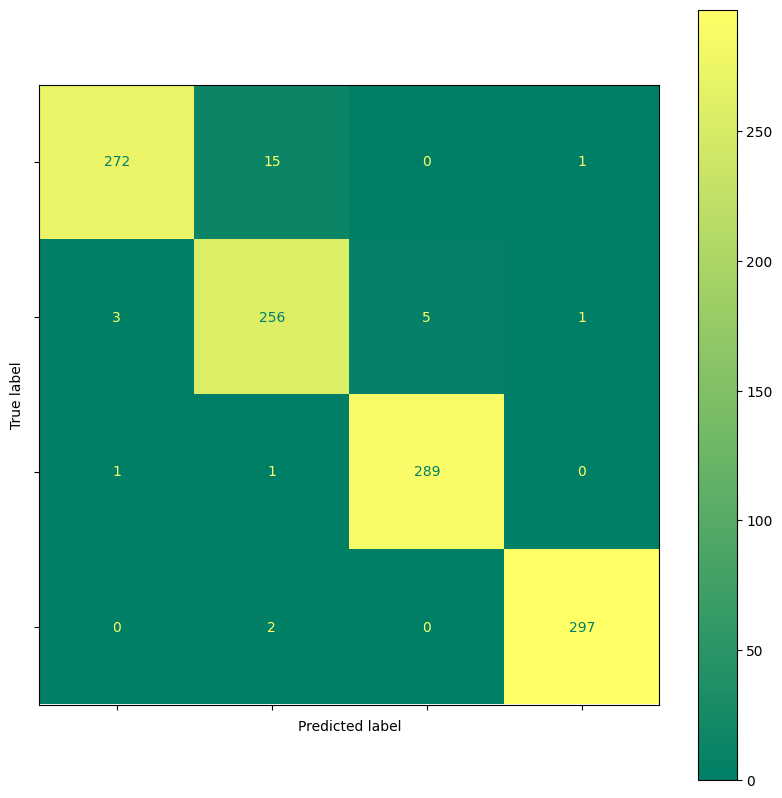

In [167]:
evaluation = model.evaluate(X_val, Y_val)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
Y_val_indices = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_val_indices, y_pred)


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=CATEGORIES)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [168]:
print(classification_report(Y_val_indices, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       288
           1       0.93      0.97      0.95       265
           2       0.98      0.99      0.99       291
           3       0.99      0.99      0.99       299

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.98      0.97      0.97      1143



1
 Image 100 is meningioma
1/1 [==============================] - 0s 131ms/step
The model predict that image 100 is meningioma


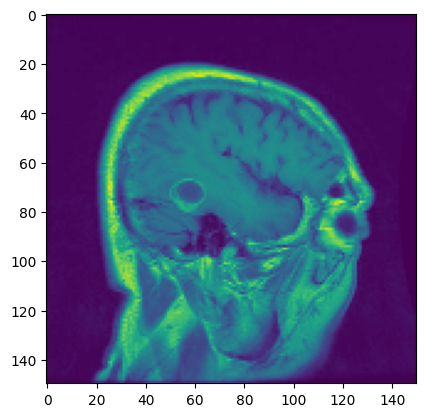

In [181]:
my_image = X_val[100]
plt.imshow(my_image)


label_index = np.argmax(Y_train[100])
print(label_index)

print(f" Image 100 is {CATEGORIES[label_index]}")

# correctly predicted as a pituitary
pred_100 = np.argmax(model.predict(my_image.reshape(1, 150, 150, 1)))
print(f"The model predict that image 100 is {CATEGORIES[pred_100]}")

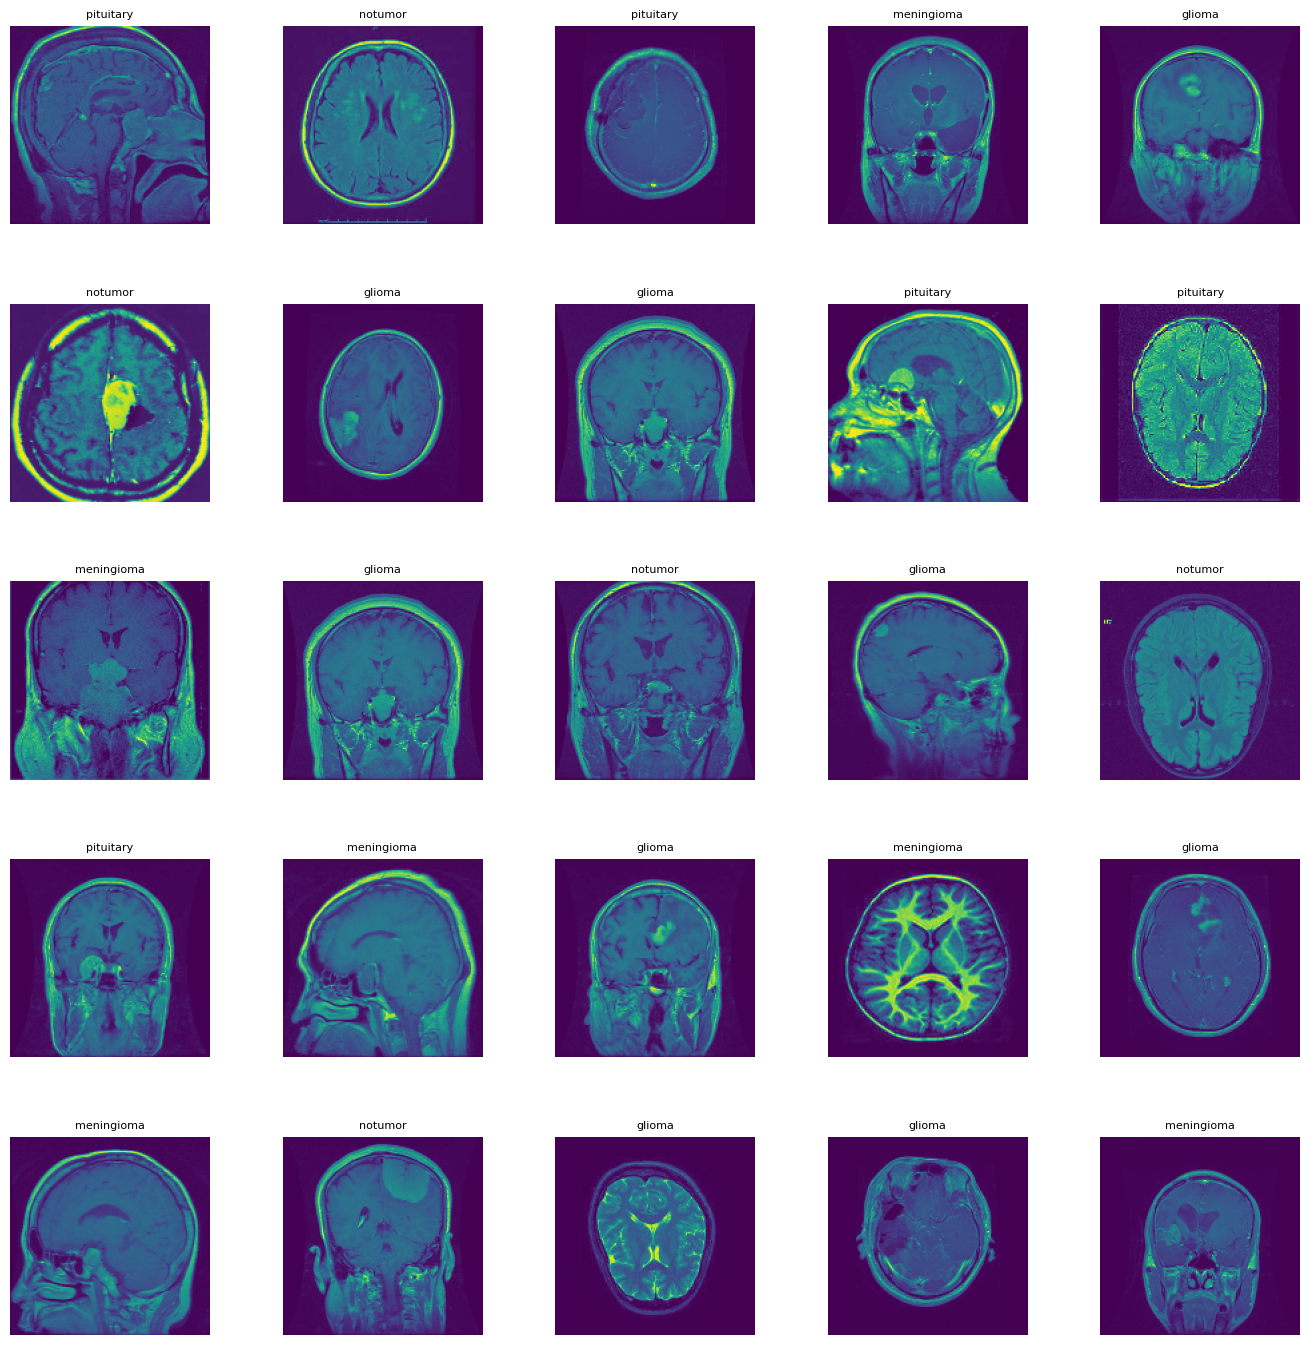

In [178]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_val) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_val[index,1:])
    label_index = np.argmax(Y_train[index])
    axes[i].set_title(CATEGORIES[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [179]:
def plot_image(i, predictions_array, true_label, img):
    # print(f"true_label before {true_label}")
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    # print(f"predictedt_label: {predicted_label}")
    # print(f"true_label: {true_label}")

    plt.xlabel(f"{CATEGORIES[predicted_label]} {100*np.max(predictions_array):2.0f}% ({CATEGORIES[np.argmax(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(np.argmax(true_label[i]))
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

36/36 [==============================] - 27s 736ms/step


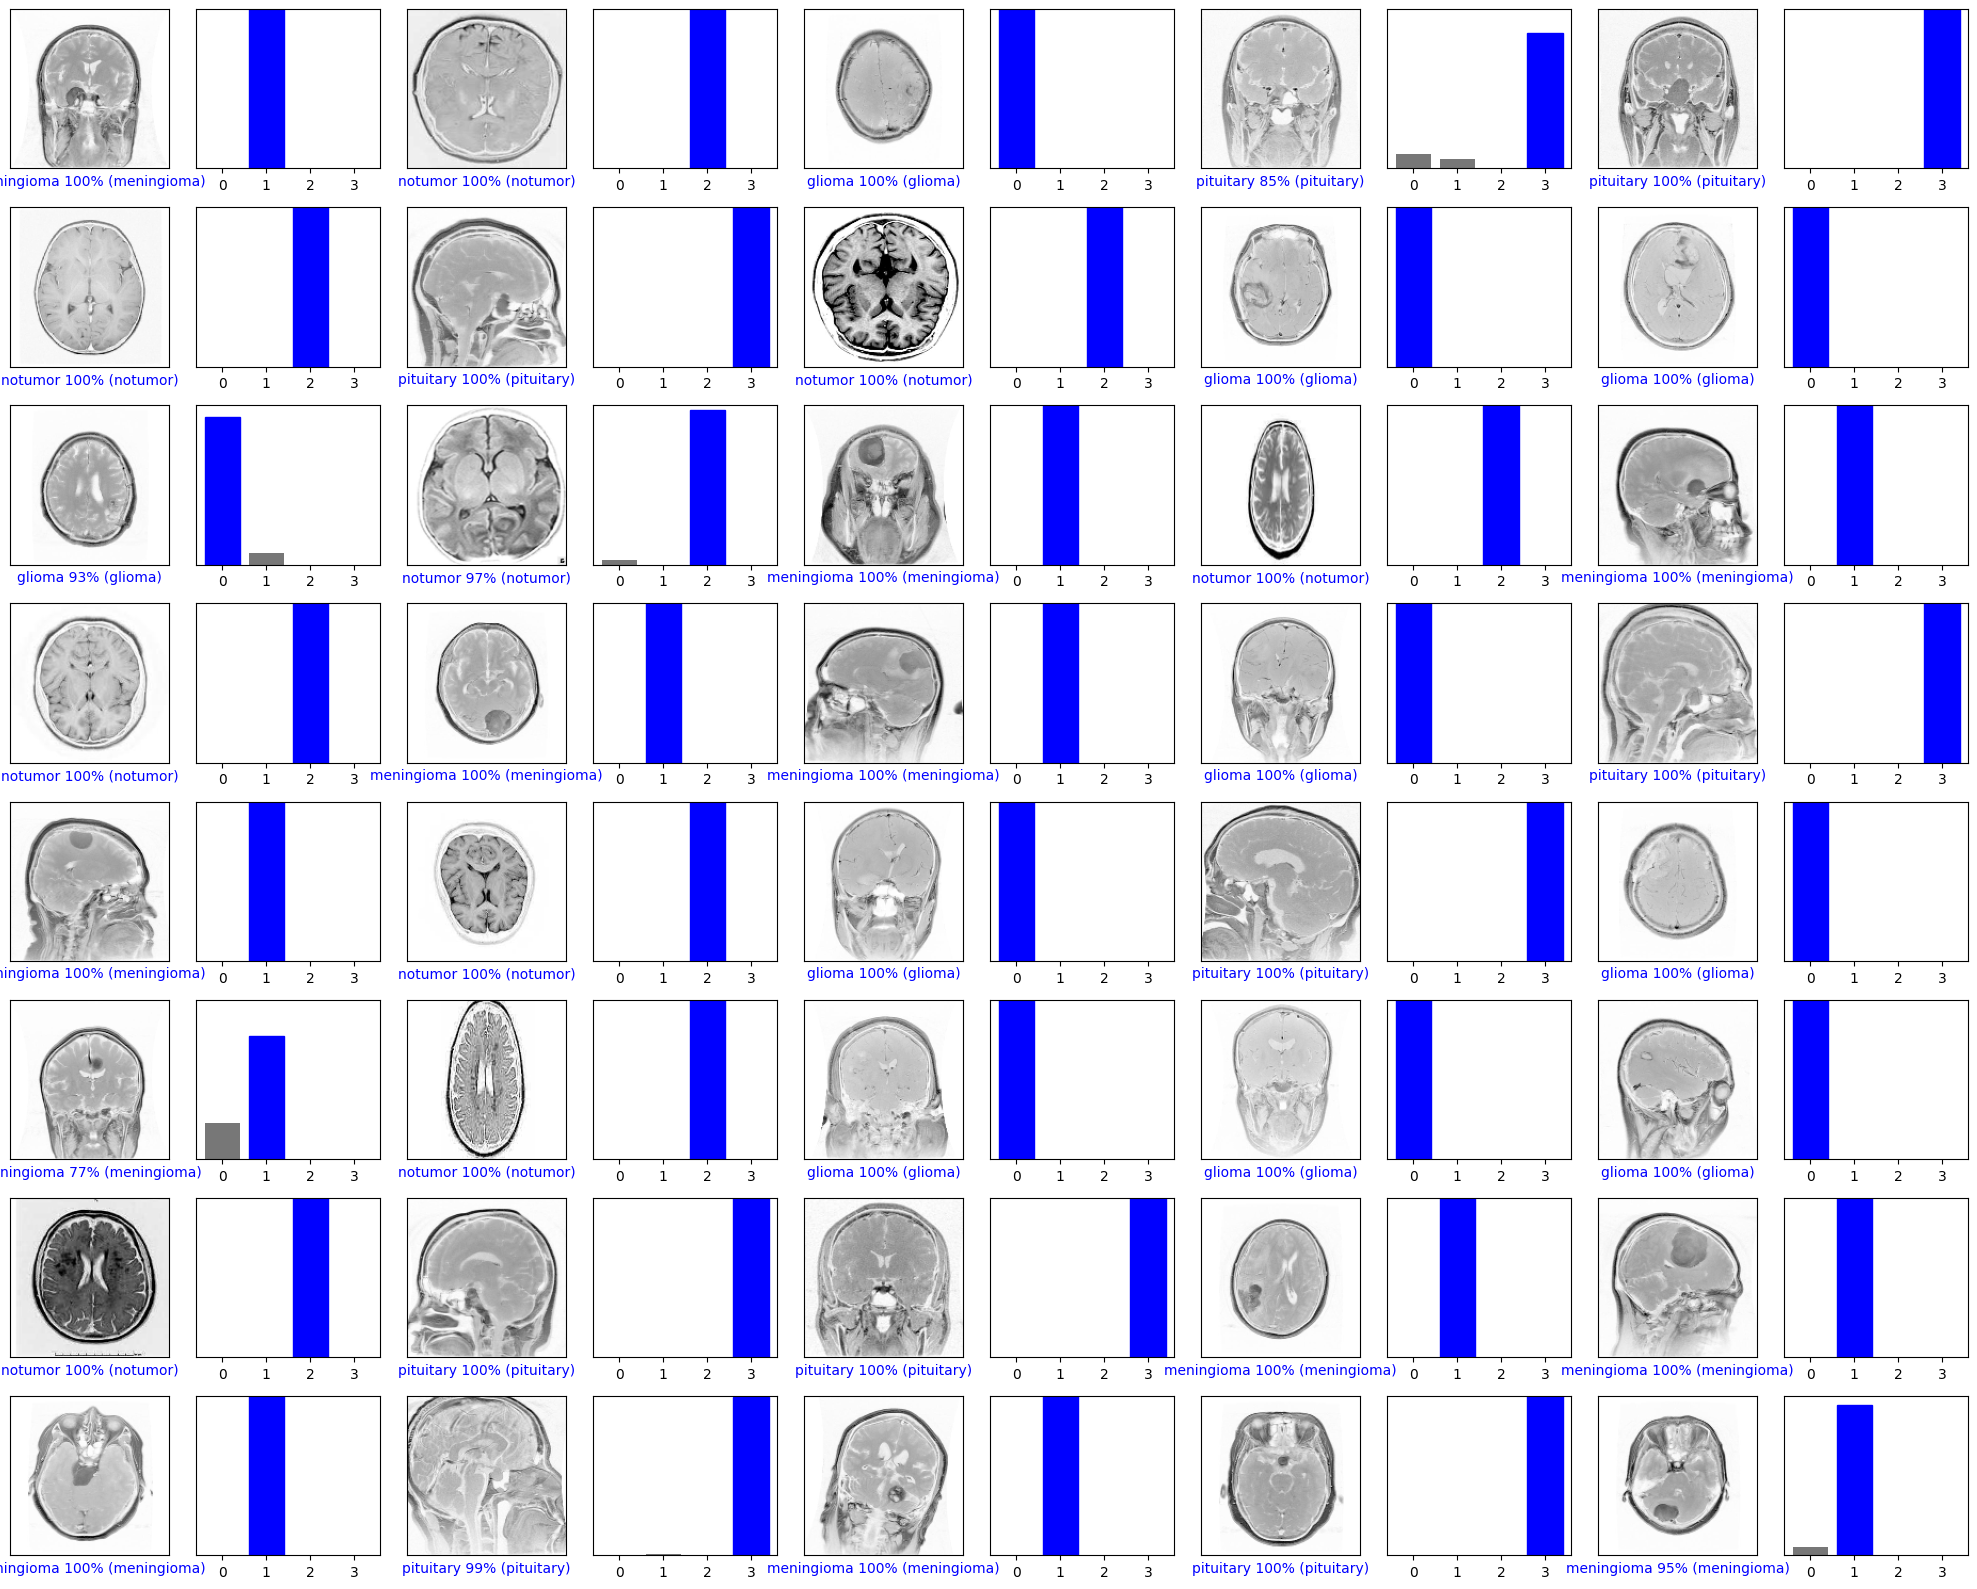

In [180]:
predictions = model.predict(X_val)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], Y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], Y_val)
plt.tight_layout()
plt.show()

In [182]:
model.save('BrainTumorClassifier.h5')